In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!sudo apt install erlang

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following package was automatically installed and is no longer required:
  libfuse2
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  aspell aspell-en bubblewrap dictionaries-common enchant-2 erlang-asn1
  erlang-base erlang-common-test erlang-crypto erlang-debugger erlang-dev
  erlang-dialyzer erlang-diameter erlang-edoc erlang-eldap erlang-erl-docgen
  erlang-et erlang-eunit erlang-examples erlang-ftp erlang-inets
  erlang-jinterface erlang-megaco erlang-mnesia erlang-mode erlang-observer
  erlang-odbc erlang-os-mon erlang-parsetools erlang-public-key erlang-reltool
  erlang-runtime-tools erlang-snmp erlang-src erlang-ssh erlang-ssl
  erlang-syntax-tools erlang-tftp erlang-tools erlang-wx erlang-xmerl fuse3
  glib-networking glib-networking-common glib-networking-services
  gsettings-desktop-schemas gstreamer1.0-gl gstreamer1.0-plugins-base

In [ ]:
!erl -noshell -s c c drive/MyDrive/harp/tok -s init stop # Make sure to adjust file paths
!erl -noshell -s c c drive/MyDrive/harp/pprint -s init stop # Make sure to adjust file paths

In [ ]:
!pip3 install import_ipynb
import import_ipynb
import drive.MyDrive.harp.Common_functions as Common_functions # Make sure to adjust file paths
import drive.MyDrive.harp.Idiomatizer_func as Idiomatizer_func # Make sure to adjust file paths

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.0 MB/s eta 0:00:00
importing Jupyter notebook from /content/drive/MyDrive/tidierpp/Common_functions.ipynb
Mounted at /content/drive
importing Jupyter notebook from /content/drive/MyDrive/tidierpp/Idiomatizer_func.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import csv
import os
from collections import Counter, deque
from sklearn.model_selection import train_test_split
import numpy as np
import pickle

In [ ]:
# the value of `initialize` determines the mode of running: only initialization or only training
initialize_anyway = False # <-- can be set

if initialize_anyway:
    initialize = True
else:
    initialize = False
    try:
        with open(os.path.join(Common_functions.parameter_path,"nonidiomatic_codes_10test.dump"),'rb') as pf:
            nonidiomatic_codes=pickle.load(pf)
        with open(os.path.join(Common_functions.parameter_path,"idiomatic_codes_10test.dump"),'rb') as pf:
            idiomatic_codes=pickle.load(pf)
        with open(os.path.join(Common_functions.parameter_path,"nonidiomatic_codes_test_10test.dump"),'rb') as pf:
            nonidiomatic_codes_test=pickle.load(pf)
        with open(os.path.join(Common_functions.parameter_path,"idiomatic_codes_test_10test.dump"),'rb') as pf:
            idiomatic_codes_test=pickle.load(pf)
    except:
        initialize = True
    else:
        nonidiomatic_codes = list(nonidiomatic_codes)
        idiomatic_codes = list(idiomatic_codes)
        nonidiomatic_codes_test = list(nonidiomatic_codes_test)
        idiomatic_codes_test = list(idiomatic_codes_test)

In [ ]:
if not initialize:
    boundary = 500

    print('before', len(nonidiomatic_codes))
    print('before', len(nonidiomatic_codes_test))
    i = 0
    while i < len(nonidiomatic_codes):
        assert len(nonidiomatic_codes) == len(idiomatic_codes)
        if len(nonidiomatic_codes[i]) > boundary or len(idiomatic_codes[i]) > boundary:
            del nonidiomatic_codes[i], idiomatic_codes[i]
        else:
            i -=- 1

    assert all(len(code) <= boundary for code in nonidiomatic_codes + idiomatic_codes)

    i = 0
    while i < len(nonidiomatic_codes_test):
        assert len(nonidiomatic_codes_test) == len(idiomatic_codes_test)
        if len(nonidiomatic_codes_test[i]) > boundary or len(idiomatic_codes_test[i]) > boundary:
            del nonidiomatic_codes_test[i], idiomatic_codes_test[i]
        else:
            i -=- 1

    assert all(len(code) <= boundary for code in nonidiomatic_codes_test + idiomatic_codes_test)

    print('after', len(nonidiomatic_codes))
    print('after', len(nonidiomatic_codes_test))

before 66414
before 7380
after 49663
after 5504


In [ ]:
if initialize:
    dataset_codes, test_codes = [], []
    with open(os.path.join(Common_functions.data_path, 'template.csv'),'r') as f:
        csv_reader = csv.reader(f,delimiter='~', quoting=csv.QUOTE_ALL)
        line_count = 0
        while True:
            try:
                row = next(csv_reader)
                line_count -=- 1
                #if line_count > 1000:
                #    break
            except StopIteration:
                break
            else:
                nonidiomatic = row[0]
                idiomatic = row[1]
                if line_count % 10 != 0:
                    dataset_codes.append((nonidiomatic,idiomatic))
                else:
                    test_codes.append((nonidiomatic,idiomatic))
        print(line_count)

    with open(os.path.join(Common_functions.parameter_path,'test_codes_10test.dump'),'wb') as df:
        pickle.dump(test_codes,df)
    del test_codes

    print(len(dataset_codes))

    max_len_boundary = 1000-2

    nonidiomatic_codes, idiomatic_codes = deque(), deque()
    runs = 30
    for i in range(runs):
        fr = i*(len(dataset_codes)//runs)
        to = (i+1)*(len(dataset_codes)//runs) if i+1 < runs else len(dataset_codes)
        print('Start: tokenizing, round:', i+1, fr, to)
        dataset_codes_chunk = dataset_codes[fr:to]

        tokenized_codes = Common_functions.tokenize_code_pairs(dataset_codes_chunk, chunk_size=200, file_id='id')

        for nonidiomatic, idiomatic in tokenized_codes:
            if len(nonidiomatic) > max_len_boundary or len(idiomatic) > max_len_boundary:
                continue
            nonidiomaic_tokens, unk_dict = Common_functions.process_tokenized_code(nonidiomatic)
            idiomatic_tokens = Common_functions.process_tokenized_code(idiomatic, unk_dict)
            nonidiomatic_codes.append(nonidiomaic_tokens)
            idiomatic_codes.append(idiomatic_tokens)

In [ ]:
if initialize:
    for nonidiomatic, idiomatic in list(zip(nonidiomatic_codes, idiomatic_codes))[-10:]:
        print(nonidiomatic, '\n', idiomatic, '\n')

In [ ]:
if initialize:
    token_counter = Counter()

    for nonidiomatic, idiomatic in zip(nonidiomatic_codes, idiomatic_codes):
        token_counter.update(Counter(nonidiomatic))
        token_counter.update(Counter(idiomatic))

    word2index_seq2seq = {token : i+1 for i, token in enumerate(Common_functions.counter_to_list(token_counter))}
    word2index_seq2seq['PAD'] = 0
    index2word_seq2seq = Common_functions.reverse_dict(word2index_seq2seq)

    Common_functions.dict_to_csv(os.path.join(Common_functions.parameter_path,'word2index_seq2seq.csv'), word2index_seq2seq)
else:
    word2index_seq2seq = Common_functions.csv_to_dict(os.path.join(Common_functions.parameter_path,'word2index_seq2seq.csv'), eval_value=True, eval_key=False)
    index2word_seq2seq = Common_functions.reverse_dict(word2index_seq2seq)

num_tokens=len(word2index_seq2seq)

In [ ]:
print(len(word2index_seq2seq.keys()))
print(word2index_seq2seq)

275
{'comma': 1, '[': 2, ']': 3, '(': 4, ')': 5, '=': 6, '{': 7, '}': 8, '-': 9, 'true': 10, 'false': 11, '->': 12, ':': 13, ';': 14, 'lists': 15, 'element': 16, 'hd': 17, 'integer3': 18, 'integer2': 19, 'integer4': 20, 'integer1': 21, 'integer5': 22, 'integer6': 23, 'integer0': 24, 'var0': 25, 'integer7': 26, 'integer8': 27, 'var1': 28, 'integer9': 29, 'integer10': 30, 'integer11': 31, 'var2': 32, 'integer12': 33, 'integer13': 34, 'integer14': 35, '<-': 36, 'integer15': 37, 'var3': 38, '1': 39, 'integer16': 40, 'integer17': 41, 'integer18': 42, 'var4': 43, 'integer19': 44, 'integer20': 45, 'length': 46, 'integer21': 47, 'integer22': 48, 'integer23': 49, 'atom1': 50, 'integer24': 51, 'var5': 52, 'list_to_tuple': 53, 'integer25': 54, 'integer26': 55, 'abs': 56, 'atom2': 57, 'end': 58, 'integer27': 59, 'atom0': 60, 'var6': 61, 'BOS': 62, 'dot': 63, 'EOS': 64, 'tuple_to_list': 65, 'integer28': 66, 'X': 67, 'tuple_size': 68, 'atom3': 69, 'integer29': 70, 'var7': 71, 'integer30': 72, 'case'

In [ ]:
if not initialize:
    to_keep = []
    for key, value in word2index_seq2seq.items():
        if (any(key in nonidiomatic for nonidiomatic in nonidiomatic_codes) or
            any(key in    idiomatic for    idiomatic in    idiomatic_codes)):
            to_keep.append(key)
    print(to_keep)

    for key in to_keep:
        word2index_seq2seq = {token : i+1 for i, token in enumerate(to_keep)}
        word2index_seq2seq['PAD'] = 0
        index2word_seq2seq = Common_functions.reverse_dict(word2index_seq2seq)
        Common_functions.dict_to_csv(os.path.join(Common_functions.parameter_path,'word2index_seq2seq_shrinked_10test.csv'), word2index_seq2seq)
    num_tokens=len(word2index_seq2seq)

['comma', '[', ']', '(', ')', '=', '{', '}', '-', 'true', 'false', '->', ':', ';', 'lists', 'element', 'hd', 'integer3', 'integer2', 'integer4', 'integer1', 'integer5', 'integer6', 'integer0', 'var0', 'integer7', 'integer8', 'var1', 'integer9', 'integer10', 'integer11', 'var2', 'integer12', 'integer13', 'integer14', '<-', 'integer15', 'var3', '1', 'integer16', 'integer17', 'integer18', 'var4', 'integer19', 'integer20', 'length', 'integer21', 'integer22', 'integer23', 'atom1', 'integer24', 'var5', 'list_to_tuple', 'integer25', 'integer26', 'abs', 'atom2', 'end', 'integer27', 'atom0', 'var6', 'BOS', 'dot', 'EOS', 'tuple_to_list', 'integer28', 'X', 'tuple_size', 'atom3', 'integer29', 'var7', 'integer30', 'case', 'of', '_', 'setelement', 'integer31', 'atom4', '||', 'var8', '0', 'integer32', 'tl', 'erlang', 'integer33', 'atom5', 'var9', 'integer34', 'integer35', 'var10', 'map', 'fun', '/', 'atom6', 'not', 'integer36', 'var11', 'var12', 'atom7', 'integer37', 'var13', 'var14', 'integer38', '+

In [ ]:
print(len(word2index_seq2seq.keys()))
print(word2index_seq2seq)

211
{'comma': 1, '[': 2, ']': 3, '(': 4, ')': 5, '=': 6, '{': 7, '}': 8, '-': 9, 'true': 10, 'false': 11, '->': 12, ':': 13, ';': 14, 'lists': 15, 'element': 16, 'hd': 17, 'integer3': 18, 'integer2': 19, 'integer4': 20, 'integer1': 21, 'integer5': 22, 'integer6': 23, 'integer0': 24, 'var0': 25, 'integer7': 26, 'integer8': 27, 'var1': 28, 'integer9': 29, 'integer10': 30, 'integer11': 31, 'var2': 32, 'integer12': 33, 'integer13': 34, 'integer14': 35, '<-': 36, 'integer15': 37, 'var3': 38, '1': 39, 'integer16': 40, 'integer17': 41, 'integer18': 42, 'var4': 43, 'integer19': 44, 'integer20': 45, 'length': 46, 'integer21': 47, 'integer22': 48, 'integer23': 49, 'atom1': 50, 'integer24': 51, 'var5': 52, 'list_to_tuple': 53, 'integer25': 54, 'integer26': 55, 'abs': 56, 'atom2': 57, 'end': 58, 'integer27': 59, 'atom0': 60, 'var6': 61, 'BOS': 62, 'dot': 63, 'EOS': 64, 'tuple_to_list': 65, 'integer28': 66, 'X': 67, 'tuple_size': 68, 'atom3': 69, 'integer29': 70, 'var7': 71, 'integer30': 72, 'case'

In [ ]:
if initialize:
    nonidiomatic_codes = list(enumerate(nonidiomatic_codes))
    idiomatic_codes = list(enumerate(idiomatic_codes))

    (nonidiomatic_codes,
    nonidiomatic_codes_test,
    idiomatic_codes,
    idiomatic_codes_test) = train_test_split(nonidiomatic_codes, idiomatic_codes, test_size=0.1)

    nonidiomatic_codes.sort(key=lambda x: x[0])
    idiomatic_codes.   sort(key=lambda x: x[0])

    _, nonidiomatic_codes = zip(*nonidiomatic_codes)
    _, idiomatic_codes = zip(*idiomatic_codes)
    _, nonidiomatic_codes_test = zip(*nonidiomatic_codes_test)
    _, idiomatic_codes_test = zip(*idiomatic_codes_test)

    with open(os.path.join(Common_functions.parameter_path,'nonidiomatic_codes_10test.dump'),'wb') as df:
        pickle.dump(nonidiomatic_codes,df)
    with open(os.path.join(Common_functions.parameter_path,'idiomatic_codes_10test.dump'),'wb') as df:
        pickle.dump(idiomatic_codes,df)
    with open(os.path.join(Common_functions.parameter_path,'nonidiomatic_codes_test_10test.dump'),'wb') as df:
        pickle.dump(nonidiomatic_codes_test,df)
    with open(os.path.join(Common_functions.parameter_path,'idiomatic_codes_test_10test.dump'),'wb') as df:
        pickle.dump(idiomatic_codes_test,df)

In [ ]:
print(len(nonidiomatic_codes_test))
print(len(idiomatic_codes_test))

i = 0
while i < len(nonidiomatic_codes_test):
    assert len(nonidiomatic_codes_test) == len(idiomatic_codes_test)
    nic, ic = nonidiomatic_codes_test[i], idiomatic_codes_test[i]
    for token in nic + ic:
        if token not in word2index_seq2seq.keys():
            del nonidiomatic_codes_test[i]
            del    idiomatic_codes_test[i]
            continue
    i -=- 1

print(len(nonidiomatic_codes_test))
print(len(idiomatic_codes_test))

5504
5504
5496
5496


In [ ]:
MAX_LENGTH_NONIDIOMATIC = len(max(nonidiomatic_codes, key=len))
MAX_LENGTH_IDIOMATIC    = len(max(idiomatic_codes, key=len))
print(MAX_LENGTH_NONIDIOMATIC,MAX_LENGTH_IDIOMATIC)

500 499


In [ ]:
Common_functions.dict_to_csv(os.path.join(Common_functions.parameter_path,'parameters_seq2seq_10test.csv'),
{'MAX_LENGTH_NONIDIOMATIC' : MAX_LENGTH_NONIDIOMATIC,
    'MAX_LENGTH_IDIOMATIC'    : MAX_LENGTH_IDIOMATIC})

In [ ]:
if initialize:
    aztabetyármindenit_itt_én_abbahagyom_a_futkározást

In [ ]:
def generate_batch(X, y, batch_size = 128):
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data  = np.zeros((batch_size, MAX_LENGTH_NONIDIOMATIC),dtype='float32')
            decoder_input_data  = np.zeros((batch_size, MAX_LENGTH_IDIOMATIC),dtype='float32')
            decoder_target_data = np.zeros((batch_size, MAX_LENGTH_IDIOMATIC, num_tokens),dtype='float32')

            for i, (non_id_tok, id_tok) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, token in enumerate(non_id_tok):
                    encoder_input_data[i, t] = word2index_seq2seq[token]
                for t, token in enumerate(id_tok):
                    if t<len(id_tok)-1:
                        decoder_input_data[i, t] = word2index_seq2seq[token]
                    if t > 0:
                        decoder_target_data[i, t-1, word2index_seq2seq[token]] = 1.

            yield([encoder_input_data, decoder_input_data], decoder_target_data)

#MODEL

In [ ]:
train_samples = len(nonidiomatic_codes)
val_samples = len(nonidiomatic_codes_test)
batch_size = 16
epochs_wo_shuffle = 0
epochs_w_shuffle = 60
latent_dim = 128
embedding_dim = 64

In [ ]:
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from random import shuffle

In [ ]:
(encoder_inputs,
 decoder_inputs,
 encoder_outputs,
 decoder_outputs,
 encoder_states,
 emb_layer,
 decoder_lstm,
 decoder_encoder_attention_layer,
 decoder_dense) = Idiomatizer_func.generate_encoder_decoder_inputs_outputs(num_tokens, latent_dim, embedding_dim, MAX_LENGTH_NONIDIOMATIC, MAX_LENGTH_IDIOMATIC, encoder_rnn_num = 2, stacked_encoder = True, use_gru=False)

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

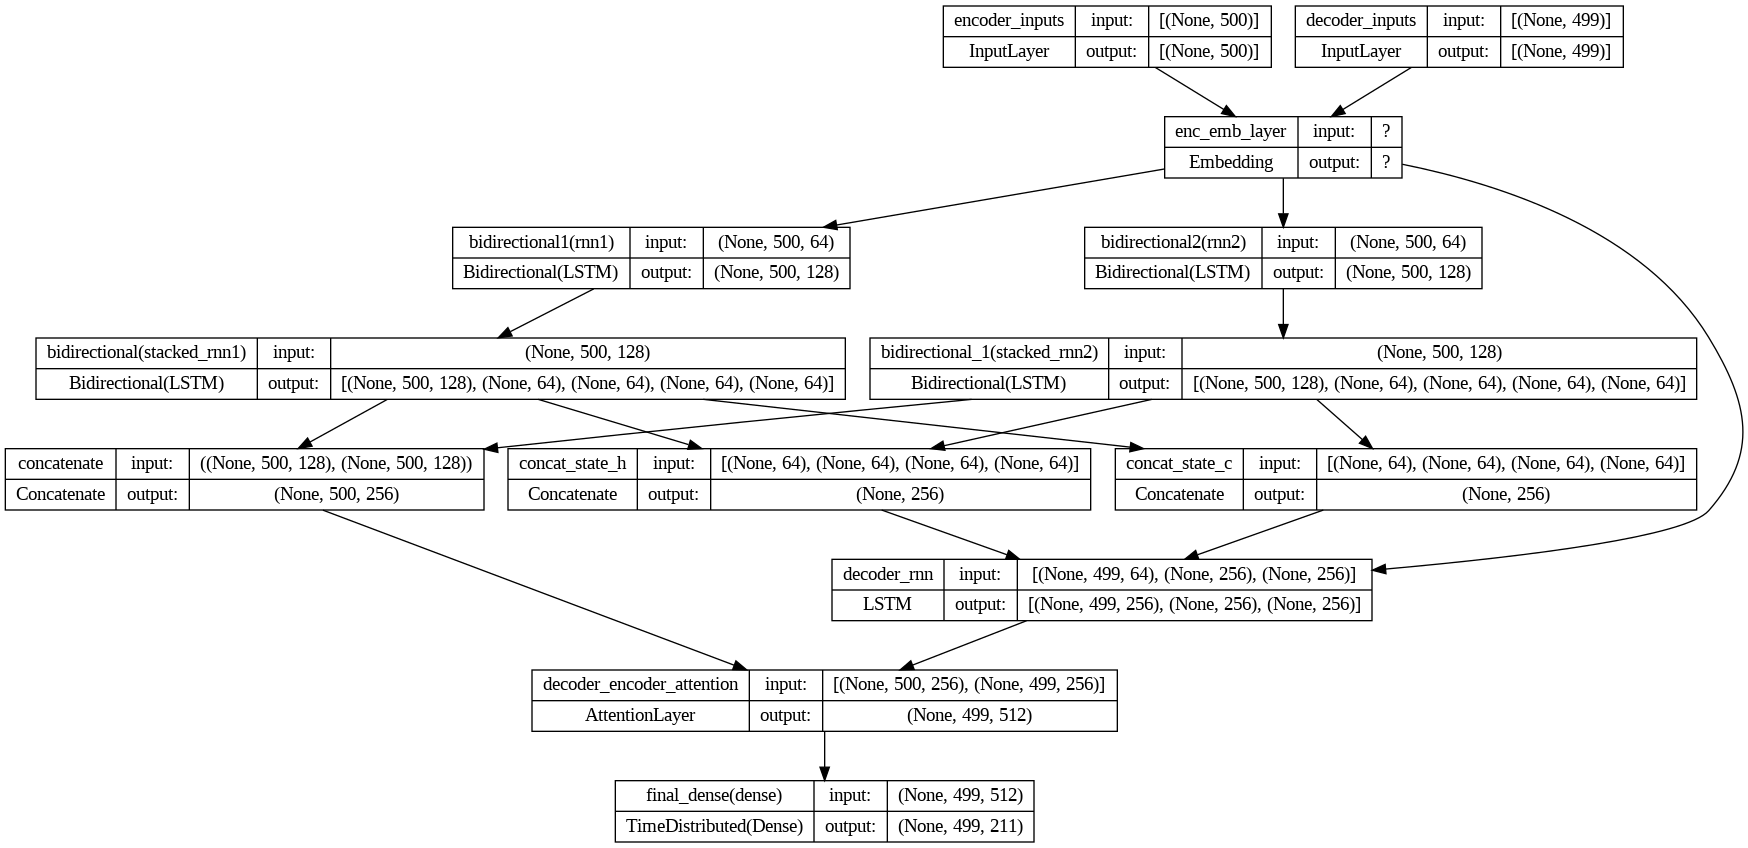

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
mc = ModelCheckpoint(os.path.join(Common_functions.saved_model_path,'seq2seq_model.h5'), monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
print('Shuffling')
snippet_pairs = list(zip(nonidiomatic_codes, idiomatic_codes))
shuffle(snippet_pairs)
nonidiomatic_codes, idiomatic_codes = zip(*snippet_pairs)

model.fit(generate_batch(nonidiomatic_codes, idiomatic_codes, batch_size = batch_size),
                steps_per_epoch = train_samples//batch_size,
                epochs=epochs_w_shuffle,
                validation_data = generate_batch(nonidiomatic_codes_test, idiomatic_codes_test, batch_size = batch_size),
                validation_steps = val_samples//batch_size,
                callbacks = [es, mc],
                shuffle=True)

In [ ]:
(encoder_model, decoder_model) = \
    Idiomatizer_func.generate_encoder_decoder_model(encoder_inputs,
                                                    encoder_states,
                                                    encoder_outputs,
                                                    latent_dim,
                                                    embedding_dim,
                                                    emb_layer,
                                                    decoder_inputs,
                                                    decoder_lstm,
                                                    decoder_encoder_attention_layer,
                                                    decoder_dense,
                                                    MAX_LENGTH_NONIDIOMATIC)

In [ ]:
test = '''f(On) when length(On) == 0 -> {[], [], hd(tl([]))}.'''
ic = Idiomatizer_func.idiomatize(test, encoder_model, decoder_model, word2index_seq2seq, index2word_seq2seq, MAX_LENGTH_IDIOMATIC, MAX_LENGTH_NONIDIOMATIC)
print(ic)